In [17]:
import import_ipynb
import random
%matplotlib inline
import matplotlib.pyplot as plt
import statistics
import warnings
import numpy as np
import copy
import scipy.stats
import networkx as nx
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from IPython.core.debugger import set_trace
warnings.filterwarnings("ignore")


In [2]:
from KEM_General import Super_General_Model
from KEM_General import General_Model_MultiCity

importing Jupyter notebook from KEM_General.ipynb


In [56]:
# For population size analysis

class General_Model_MultiCity(object):
    
    def __init__(self,obj):
        """
        Inputs:
            obj. Super_General_Model. The class of the model type you want to analyze. 
                Example: General_Model_MultiCity.run_many_pops(KEM_Grid) (note that you should not instantiate the KEM_Grid class)        
        """
        self.obj = obj
        
    def run_many_pops(self,mu=50.,avg=False,avg_step=.1,pops=None,add=False):
        """
        Inputs:
            mu. float. the average wealth of agents
            
            -- OBSELETE IF ONLY STORING FINAL TIME-STEP FOR EFFICIENCY
            avg. boolean. whether or not to average a set of the final timesteps
            avg_step. float. fraction (between 0 and 1) of a full time-step to count in the averaging
            -- OBSELETE IF ONLY STORING FINAL TIME-STEP FOR EFFICIENCY
            
            pops. list. optional input list of population sizes to run on
            add. boolean. If true, append results to existing results. If false, replace existing results
        
        Output: None
        
        Runs model simulations of varying population sizes. 
        Currently distributes city population sizes according to a zipf's law distribution
    
        """
        if not add:
            self.hists = []
        # generated by zipf's law distribution
#         self.popsizes = np.unique(np.random.zipf(1.4,300)*10)[8:30:3]
        #self.popsizes = [60,90,120,150,180,210,280,340,390,460,520,580,730,840,910,1160,1330,1610, 1820, 2910, 3970, 5130, 7430]
        if pops:
            if add:
                self.popsizes += pops
                pops_to_run = pops
            else:
                self.popsizes = pops
                pops_to_run = pops
        else:
            self.popsizes = [66000,110000]#[200,1000,5000,10000,33000,
            pops_to_run = self.popsizes
        print("popsizes:",self.popsizes)
        sims = {}
        for popsize in pops_to_run:
            # instantiate model class
            sims[popsize] = self.obj(N=popsize,mu=mu)
            print("\n NEW SIM\npopulation = ",popsize)
            #TODO: set to auto once convergence works properly
            results = sims[popsize].run(convergence="auto")
            # append distribution from last time step
            if avg:
                # average over avg_step percent of time-steps required for every agent to (on average) interact once
                d_steps = int(avg_step*sims[popsize].N/2)
                self.hists.append(np.average(np.array(results[-d_steps:]),axis=0))
            else:
                self.hists.append(results[-1])

    def save_results(self,name="UNNAMED_RESULTS"):
        """
        Saves a numpy file of the model output, using the format specified in ModelComparison.ipynb
        
        Inputs: name, name of file
        
        Output: None
        """
        
        if name == "UNNAMED_RESULTS":
            print("WARNING! Please give a proper name for results!")
        # 
        savedata = np.array(list(zip(np.array(self.popsizes),np.array(self.hists))))
        fname = name + ".npy"
        np.save(fname,savedata)
        
    def animate_population_dists(self):
        """
        
        Input: None
        
        Output: animation object
        
        Create animations of distributions. Returns animation function. 
        Run "HTML(anim.to_jshtml())" on return anim to display animation
        """
        
        fig = plt.figure()
        def animate(i):
            #label = label + ': G=' + str(round(gini(population), 2))
            plt.cla()
            lbl = "population = "+str(self.popsizes[i])
            plt.hist(self.hists[i], alpha = 0.4, bins = 45, label=lbl)
            plt.legend()
            plt.xlabel('Wealth')
            plt.ylabel('Count')
            plt.grid(True)

        anim = FuncAnimation(fig, animate, #init_func=init,
                                       #frames=76)#), interval=20)#, blit=True)
                                       frames=len(self.hists))#), interval=20)#, blit=True)
#         HTML(anim.to_jshtml())
        return anim


    def plot_moments(self):
        
        class custom_distribution(scipy.stats.rv_continuous):
            def _pdf(self, x, msa):
                ret = kde_pdfs[msa[0]](x[0])
                return ret

        distribution = custom_distribution(momtype=0)

        popsizes = popsizes[:-4]
        print(popsizes)
        print(kde_pdfs)
        set_trace()
        # maps moment number n to list of those moments
        moments = {}
        cpops = []


        for hist,psize in zip(self.hists,self.popsizes):
            for n in range(1,5):
                if n not in moments:
                    moments[n] = []
                moments[n].append(scipy.stats.moment(hist,moment=n))
                #print("moment: n, val,pop:",n,moments[n],psize)
            cpops.append(psize)



        scale_y = {
        #     1:1.,
        #     2:.5,
        #     3:.3,
        #     4:.3,
        #     5:.15
            1:1.,
            2:1.,
            3:1.,
            4:1.
        }

        #TODO: What's going on with the moments that evaluate to zero???

        for n in range(1,5):
            plt.figure()
            plt.xlabel("city population")
            lbl = "nth moment, n = " + str(n) 
            if n == 2:
                lbl = "Variance (2nd Moment)"
            elif n == 1:
                lbl = "Mean (1st Moment)"
            elif n == 3:
                lbl = "Skewness (3rd Moment)"
            elif n == 4:
                lbl = "Kurtosis (4th Moment)"
            plt.ylabel(lbl)
            # TODO: fit regressions in log-linear space, calculate R^2 & p-value
            plt.plot(cpops,moments[n],markersize=2)
            bottom,top = plt.ylim()
            plt.ylim((bottom,scale_y[n]*top))
            #plt.yscale("log")
            plt.xscale("log")
            plt.show()
            plt.close()


    def animate_distributions(self,times=[0,1],n_frames=100,average=True):
        """
        
        Inputs:
            times. list of ints (length = 2). starting and ending times to run
            n_frames. int. number of frames in animation
            
            -- OBSELETE IF ONLY STORING FINAL TIME-STEP FOR EFFICIENCY
            average. bool. If true, will average distributions over all distributions between each timeframe.
                Number of averaged time_steps = round(times[1]/n_frames))
            -- OBSELETE IF ONLY STORING FINAL TIME-STEP FOR EFFICIENCY

        
        Output: 
            animation object
        
        animates distributions over time in simulation
        
        """

        print("at start of function")
        pop_series = self.results
        run_times = []

        duration = times[1]-times[0]
        tstep = round(float(duration)/n_frames)

        max_t = self.time

        fig = plt.figure()
        print("before animate")
        def animate(i):
            print("starting animate")
            #label = label + ': G=' + str(round(gini(population), 2))
            plt.cla()
            time = times[0]+i*tstep
            if time < max_t:
                print("within if-statement")
                # take average 
                if average:
                    plotvals = np.average(pop_series[time:(time+tstep)],axis=0)
                else:
                    plotvals = pop_series[time]
                print("before hist")
                plt.hist(plotvals, alpha = 0.4, bins = 30, label=str(time))
                print("after hist")
                plt.legend()
                plt.xlabel('Wealth')
                plt.ylabel('Count')
                plt.grid(True)
                

        anim = FuncAnimation(fig, animate, #init_func=init,
                                       frames=n_frames)#), interval=20)#, blit=True)
        HTML(anim.to_jshtml())
        return anim

        


In [62]:
# Simulation with purely random interactions

class Pure_Random(Super_General_Model):
    

    class Agent:
        def __init__(self,income=0.,lambda_=0.):
            self.income = income  
            self.lambda_ = lambda_
            

    #initial values (population size & mean of the income distribution)
    def populate(self,n=500,mu=50.):
        """
        initialize population with distribution of income and parameters (e.g. lambda) applied to agents
        within structure (e.g. grid)
        
        """
        self.N=n
        self.time = 0
        incomes = [np.random.uniform(0, mu*2.) for actor in range(n)]
        
        # lambda values
        min_lambda = 0.2
        max_lambda = 0.9
        lambda_ = np.random.power(0.3,n)
        # rescale lambda
        lambda_ *= max_lambda - min_lambda
        lambda_ += min_lambda
        
        
        maxlambda = 0.97
        i = 0
        # make sure no lambdas are above 1
        for l in lambda_:
            if l >=maxlambda:
                lambda_[i] = np.random.power(.3)
                if lambda_[i]>=maxlambda:
                    lambda_[i] = 0.9
            i+=1
                
        self.population = []
        for inc,lam in zip(incomes,lambda_):
            self.population.append(self.Agent(income=inc,lambda_=lam))
        self.population = np.array(self.population)
    
  
    
    def choose_agents(self):
        """
        Input: None
        
        Output: A pair of agents who are going to interact. This becomes the input to interact
       
        Takes two actors randomly

        """
        loc_a,loc_b = random.sample(range(self.N), 2)
        return self.population[loc_a],self.population[loc_b]
    
    def get_lambda_dist(self):
        """
        returns the income distribution as a list of incomes
        """
        return [a.lambda_ for a in self.population]
    
    def get_income_dist(self):
        """
        returns the income distribution as a list of incomes
        """
        return [a.income for a in self.population]
    
    
    def interact(self,agents):
        """
        Input: Return value of choose_agents, the agents to interact
        
        Output: list of agent incomes
        
        Changes selected agent incomes/wealths according to KEM interaction mechanism and return new distribution
        """
        eps = np.random.uniform()
        A,B = agents
        A.income,B.income = A.lambda_*A.income + eps*((1-A.lambda_) * A.income + (1 - B.lambda_)*B.income), B.lambda_*B.income + (1-eps)*((1 - A.lambda_) * A.income + (1 - B.lambda_)*B.income) 
        return self.get_income_dist()
     
                
      
        
    def show_convergence_plots(self, populations=[10**2,10**3,10**4,10**5]):#,converge_params=[0.15,0.003,0.03]):
        """
        
        shows plots of moments vs. time to show how the distribution is converging across varying populations
        
        """

        for pop in populations:
            print("\n\n NEW SIM. POPULATION = %s"%pop)
            self.reset()
            self.populate(n=pop,mu=self.mu)
            self.run(convergence="auto",debug=True)
            dmdtvals = np.array(self.dmdt_vals)
#             m2s,m3s,m4s = dmdtvals[:,0],dmdtvals[:,1],dmdtvals[:,2]
            m3s = dmdtvals[:,0]#,dmdtvals[:,1],dmdtvals[:,2]
            t = list(range(len(m3s)))
            plt.figure()
            plt.title("3rd moment")
            plt.plot(t,m3s)
            plt.show()
            plt.close()
            
    def plot_lambda_income(self):
        """
        plots lambda vs. income for every agent
        
        """
        
        
        l = []
        i = []
        for agent in sim.population:
            l.append(agent.lambda_)
            i.append(agent.income)

        plt.figure()
        plt.plot(l,i,'o',markersize=1)
        plt.xlabel("Lambda")
        plt.ylabel("Income")
        plt.yscale('log')
        plt.xscale('log')
        plt.show()
        # plt.close()
        


In [63]:
meta_sim_fast = General_Model_MultiCity(Pure_Random)
# TODO: Converging too early, especially for large ones
# meta_sim_fast.run_many_pops(pops=[1000000000])
sim = Pure_Random(N=1000000)
sim.show_convergence_plots()




 NEW SIM. POPULATION = 100
max time:  25000.0
at t: 250
at t: 500
at t: 750
at t: 1000
at t: 1250
at t: 1500
at t: 1750
at t: 2000
at t: 2250
at t: 2500
at t: 2750
at t: 3000
at t: 3250
at t: 3500
at t: 3750
at t: 4000
at t: 4250
at t: 4500
at t: 4750
at t: 5000
at t: 5250
at t: 5500
at t: 5750
at t: 6000
at t: 6250
finished


IndexError: index 1 is out of bounds for axis 1 with size 1



 NEW SIM. POPULATION = 250
max time:  62500.0
at t: 124
at t: 186
at t: 248
at t: 310
at t: 372
at t: 434
at t: 496
at t: 558
at t: 620
at t: 682
at t: 744
at t: 806
at t: 868
at t: 930
at t: 992
at t: 1054
at t: 1116
at t: 1178
at t: 1240
at t: 1302
at t: 1364
at t: 1426
at t: 1488
at t: 1550
at t: 1612
at t: 1674
at t: 1736
at t: 1798
at t: 1860
at t: 1922
at t: 1984
at t: 2046
at t: 2108
at t: 2170
at t: 2232
at t: 2294
at t: 2356
at t: 2418
at t: 2480
at t: 2542
at t: 2604
at t: 2666
at t: 2728
at t: 2790
at t: 2852
at t: 2914
at t: 2976
at t: 3038
at t: 3100
at t: 3162
at t: 3224
at t: 3286
at t: 3348
at t: 3410
at t: 3472
at t: 3534
at t: 3596
at t: 3658
at t: 3720
at t: 3782
at t: 3844
at t: 3906
at t: 3968
at t: 4030
at t: 4092
at t: 4154
at t: 4216
at t: 4278
at t: 4340
at t: 4402
at t: 4464
at t: 4526
at t: 4588
at t: 4650
at t: 4712
at t: 4774
at t: 4836
at t: 4898
at t: 4960
at t: 5022
at t: 5084
at t: 5146
at t: 5208
at t: 5270
at t: 5332
at t: 5394
at t: 5456
at t: 5518

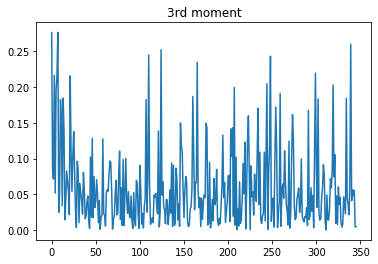



 NEW SIM. POPULATION = 1000
max time:  250000.0
at t: 250
at t: 500
at t: 750
at t: 1000
at t: 1250
at t: 1500
at t: 1750
at t: 2000
at t: 2250
at t: 2500
at t: 2750
at t: 3000
at t: 3250
at t: 3500
at t: 3750
at t: 4000
at t: 4250
at t: 4500
at t: 4750
at t: 5000
at t: 5250
at t: 5500
at t: 5750
at t: 6000
finished


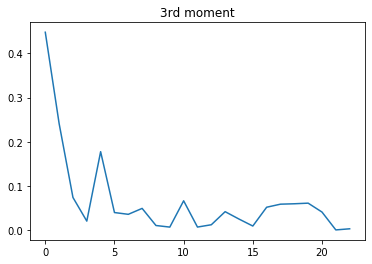



 NEW SIM. POPULATION = 1000
max time:  250000.0
at t: 250
at t: 500
at t: 750
at t: 1000
at t: 1250
at t: 1500
at t: 1750
at t: 2000
at t: 2250
at t: 2500
at t: 2750
at t: 3000
at t: 3250
at t: 3500
at t: 3750
at t: 4000
at t: 4250
at t: 4500
at t: 4750
at t: 5000
at t: 5250
at t: 5500
at t: 5750
at t: 6000
at t: 6250
at t: 6500
at t: 6750
at t: 7000
at t: 7250
at t: 7500
at t: 7750
at t: 8000
at t: 8250
at t: 8500
at t: 8750
at t: 9000
at t: 9250
at t: 9500
at t: 9750
at t: 10000
at t: 10250
at t: 10500
at t: 10750
at t: 11000
at t: 11250
finished


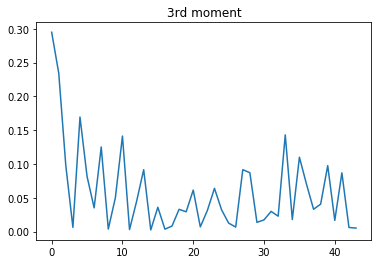



 NEW SIM. POPULATION = 2000
max time:  500000.0
at t: 500
at t: 1000
at t: 1500
at t: 2000
at t: 2500
at t: 3000
at t: 3500
at t: 4000
at t: 4500
at t: 5000
at t: 5500
at t: 6000
at t: 6500
at t: 7000
at t: 7500
at t: 8000
at t: 8500
at t: 9000
at t: 9500
at t: 10000
at t: 10500
at t: 11000
at t: 11500
at t: 12000
at t: 12500
at t: 13000
at t: 13500
at t: 14000
at t: 14500
at t: 15000
at t: 15500
at t: 16000
at t: 16500
at t: 17000
at t: 17500
at t: 18000
at t: 18500
at t: 19000
at t: 19500
at t: 20000
at t: 20500
at t: 21000
at t: 21500
at t: 22000
at t: 22500
at t: 23000
at t: 23500
at t: 24000
at t: 24500
at t: 25000
at t: 25500
at t: 26000
at t: 26500
at t: 27000
at t: 27500
at t: 28000
at t: 28500
at t: 29000
at t: 29500
at t: 30000
at t: 30500
at t: 31000
at t: 31500
at t: 32000
at t: 32500
at t: 33000
at t: 33500
at t: 34000
at t: 34500
finished


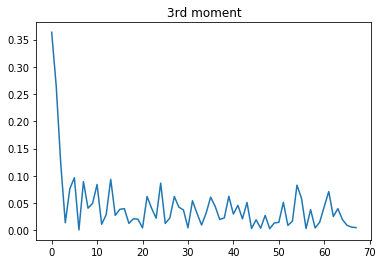



 NEW SIM. POPULATION = 2000
max time:  500000.0
at t: 500
at t: 1000
at t: 1500
at t: 2000
at t: 2500
at t: 3000
at t: 3500
at t: 4000
at t: 4500
at t: 5000
at t: 5500
at t: 6000
at t: 6500
at t: 7000
at t: 7500
at t: 8000
at t: 8500
at t: 9000
at t: 9500
at t: 10000
at t: 10500
at t: 11000
at t: 11500
at t: 12000
at t: 12500
at t: 13000
at t: 13500
at t: 14000
at t: 14500
at t: 15000
at t: 15500
at t: 16000
at t: 16500
at t: 17000
at t: 17500
at t: 18000
at t: 18500
at t: 19000
finished


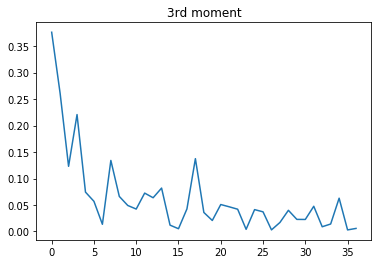



 NEW SIM. POPULATION = 3000
max time:  750000.0
at t: 750
at t: 1500
at t: 2250
at t: 3000
at t: 3750
at t: 4500
at t: 5250
at t: 6000
at t: 6750
at t: 7500
at t: 8250
at t: 9000
at t: 9750
at t: 10500
at t: 11250
at t: 12000
at t: 12750
at t: 13500
at t: 14250
at t: 15000
at t: 15750
at t: 16500
at t: 17250
at t: 18000
at t: 18750
at t: 19500
at t: 20250
at t: 21000
at t: 21750
at t: 22500
at t: 23250
at t: 24000
at t: 24750
at t: 25500
at t: 26250
at t: 27000
at t: 27750
at t: 28500
at t: 29250
at t: 30000
at t: 30750
finished


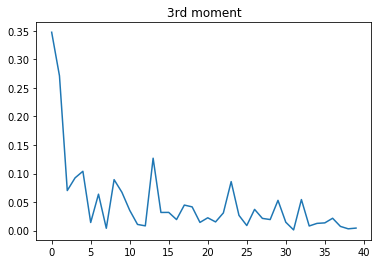



 NEW SIM. POPULATION = 3000
max time:  750000.0
at t: 750
at t: 1500
at t: 2250
at t: 3000
at t: 3750
at t: 4500
at t: 5250
at t: 6000
at t: 6750
at t: 7500
at t: 8250
at t: 9000
at t: 9750
at t: 10500
at t: 11250
at t: 12000
at t: 12750
at t: 13500
at t: 14250
at t: 15000
at t: 15750
at t: 16500
at t: 17250
at t: 18000
at t: 18750
at t: 19500
at t: 20250
at t: 21000
at t: 21750
at t: 22500
at t: 23250
at t: 24000
at t: 24750
at t: 25500
at t: 26250
at t: 27000
at t: 27750
at t: 28500
at t: 29250
at t: 30000
at t: 30750
at t: 31500
at t: 32250
at t: 33000
at t: 33750
at t: 34500
at t: 35250
at t: 36000
at t: 36750
at t: 37500
at t: 38250
at t: 39000
at t: 39750
at t: 40500
at t: 41250
at t: 42000
at t: 42750
finished


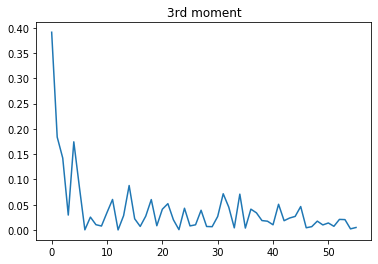



 NEW SIM. POPULATION = 4000
max time:  1000000.0
at t: 1000
at t: 2000
at t: 3000
at t: 4000
at t: 5000
at t: 6000
at t: 7000
at t: 8000
at t: 9000
at t: 10000
at t: 11000
at t: 12000
at t: 13000
at t: 14000
at t: 15000
at t: 16000
at t: 17000
at t: 18000
at t: 19000
at t: 20000
at t: 21000
at t: 22000
at t: 23000
at t: 24000
at t: 25000
at t: 26000
at t: 27000
at t: 28000
at t: 29000
at t: 30000
at t: 31000
at t: 32000
at t: 33000
at t: 34000
at t: 35000
at t: 36000
at t: 37000
at t: 38000
at t: 39000
at t: 40000
at t: 41000
at t: 42000
at t: 43000
at t: 44000
at t: 45000
at t: 46000
at t: 47000
at t: 48000
at t: 49000
at t: 50000
at t: 51000
at t: 52000
at t: 53000
at t: 54000
at t: 55000
at t: 56000
finished


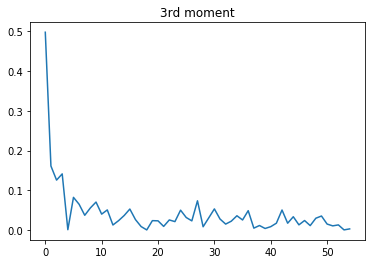



 NEW SIM. POPULATION = 4500
max time:  1125000.0
at t: 1125
at t: 2250
at t: 3375
at t: 4500
at t: 5625
at t: 6750
at t: 7875
at t: 9000
at t: 10125
at t: 11250
at t: 12375
at t: 13500
at t: 14625
at t: 15750
at t: 16875
at t: 18000
at t: 19125
at t: 20250
at t: 21375
at t: 22500
at t: 23625
at t: 24750
at t: 25875
at t: 27000
at t: 28125
at t: 29250
finished


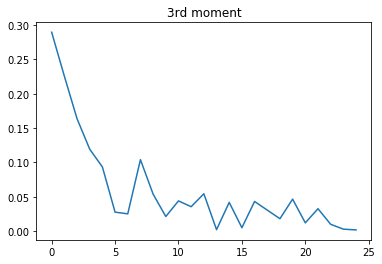



 NEW SIM. POPULATION = 5000
max time:  1250000.0
at t: 1250
at t: 2500
at t: 3750
at t: 5000
at t: 6250
at t: 7500
at t: 8750
at t: 10000
at t: 11250
at t: 12500
at t: 13750
at t: 15000
at t: 16250
at t: 17500
at t: 18750
at t: 20000
at t: 21250
at t: 22500
at t: 23750
at t: 25000
at t: 26250
at t: 27500
at t: 28750
at t: 30000
at t: 31250
at t: 32500
at t: 33750
at t: 35000
at t: 36250
at t: 37500
at t: 38750
at t: 40000
at t: 41250
at t: 42500
at t: 43750
at t: 45000
at t: 46250
at t: 47500
at t: 48750
at t: 50000
at t: 51250
at t: 52500
finished


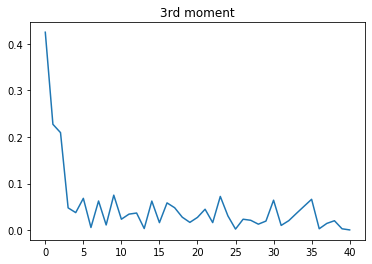



 NEW SIM. POPULATION = 5500
max time:  1375000.0
at t: 1375
at t: 2750
at t: 4125
at t: 5500
at t: 6875
at t: 8250
at t: 9625
at t: 11000
at t: 12375
at t: 13750
at t: 15125
at t: 16500
at t: 17875
at t: 19250
at t: 20625
at t: 22000
at t: 23375
at t: 24750
at t: 26125
at t: 27500
at t: 28875
at t: 30250
at t: 31625
at t: 33000
at t: 34375
at t: 35750
at t: 37125
at t: 38500
at t: 39875
at t: 41250
at t: 42625
at t: 44000
at t: 45375
at t: 46750
at t: 48125
at t: 49500
at t: 50875
at t: 52250
at t: 53625
at t: 55000
at t: 56375
at t: 57750
at t: 59125
at t: 60500
at t: 61875
at t: 63250
at t: 64625
at t: 66000
at t: 67375
at t: 68750
at t: 70125
at t: 71500
at t: 72875
at t: 74250
finished


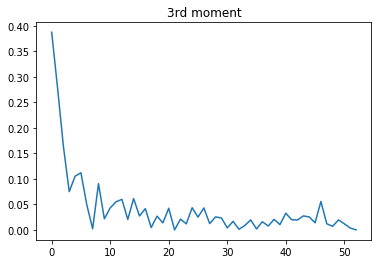



 NEW SIM. POPULATION = 6000
max time:  1500000.0
at t: 1500
at t: 3000
at t: 4500
at t: 6000
at t: 7500
at t: 9000
at t: 10500
at t: 12000
at t: 13500
at t: 15000
at t: 16500
at t: 18000
at t: 19500
at t: 21000
at t: 22500
at t: 24000
at t: 25500
at t: 27000
at t: 28500
at t: 30000
at t: 31500
at t: 33000
at t: 34500
at t: 36000
at t: 37500
at t: 39000
at t: 40500
at t: 42000
at t: 43500
at t: 45000
at t: 46500
at t: 48000
at t: 49500
at t: 51000
at t: 52500
at t: 54000
at t: 55500
at t: 57000
at t: 58500
at t: 60000
at t: 61500
at t: 63000
at t: 64500
at t: 66000
at t: 67500
at t: 69000
at t: 70500
at t: 72000
at t: 73500
at t: 75000
at t: 76500
at t: 78000
finished


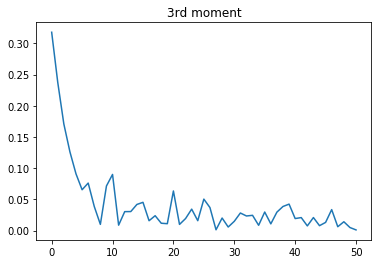



 NEW SIM. POPULATION = 7000
max time:  1750000.0
at t: 1750
at t: 3500
at t: 5250
at t: 7000
at t: 8750
at t: 10500
at t: 12250
at t: 14000
at t: 15750
at t: 17500
at t: 19250
at t: 21000
at t: 22750
at t: 24500
at t: 26250
at t: 28000
at t: 29750
at t: 31500
at t: 33250
at t: 35000
at t: 36750
at t: 38500
at t: 40250
at t: 42000
finished


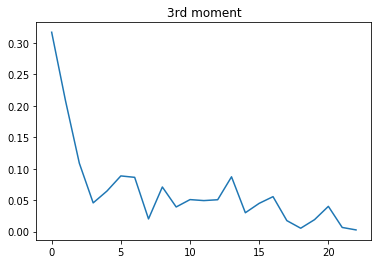



 NEW SIM. POPULATION = 7500
max time:  1875000.0
at t: 1875
at t: 3750
at t: 5625
at t: 7500
at t: 9375
at t: 11250
at t: 13125
at t: 15000
at t: 16875
at t: 18750
at t: 20625
at t: 22500
at t: 24375
at t: 26250
at t: 28125
at t: 30000
at t: 31875
at t: 33750
at t: 35625
at t: 37500
at t: 39375
at t: 41250
at t: 43125
at t: 45000
at t: 46875
at t: 48750
at t: 50625
at t: 52500
at t: 54375
at t: 56250
at t: 58125
at t: 60000
at t: 61875
finished


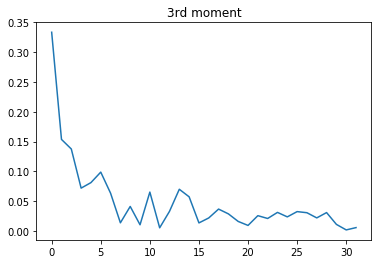



 NEW SIM. POPULATION = 8000
max time:  2000000.0
at t: 2000
at t: 4000
at t: 6000
at t: 8000
at t: 10000
at t: 12000
at t: 14000
at t: 16000
at t: 18000
at t: 20000
at t: 22000
at t: 24000
at t: 26000
at t: 28000
at t: 30000
at t: 32000
at t: 34000
at t: 36000
at t: 38000
at t: 40000
at t: 42000
at t: 44000
at t: 46000
at t: 48000
at t: 50000
at t: 52000
at t: 54000
finished


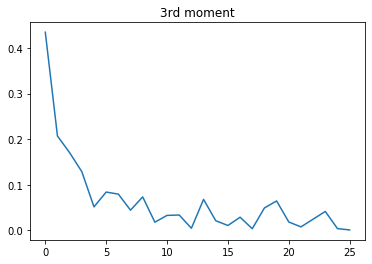



 NEW SIM. POPULATION = 8500
max time:  2125000.0
at t: 2125
at t: 4250
at t: 6375
at t: 8500
at t: 10625
at t: 12750
at t: 14875
at t: 17000
at t: 19125
at t: 21250
at t: 23375
at t: 25500
at t: 27625
at t: 29750
at t: 31875
at t: 34000
at t: 36125
at t: 38250
at t: 40375
at t: 42500
at t: 44625
at t: 46750
at t: 48875
finished


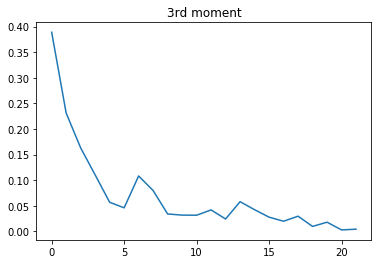



 NEW SIM. POPULATION = 9000
max time:  2250000.0
at t: 2250
at t: 4500
at t: 6750
at t: 9000
at t: 11250
at t: 13500
at t: 15750
at t: 18000
at t: 20250
at t: 22500
at t: 24750
at t: 27000
at t: 29250
at t: 31500
at t: 33750
at t: 36000
at t: 38250
at t: 40500
at t: 42750
at t: 45000
at t: 47250
at t: 49500
at t: 51750
at t: 54000
at t: 56250
at t: 58500
at t: 60750
at t: 63000
at t: 65250
at t: 67500
at t: 69750
at t: 72000
at t: 74250
at t: 76500
at t: 78750
at t: 81000
at t: 83250
at t: 85500
at t: 87750
at t: 90000
at t: 92250
at t: 94500
at t: 96750
at t: 99000
at t: 101250
at t: 103500
at t: 105750
at t: 108000
at t: 110250
at t: 112500
at t: 114750
at t: 117000
at t: 119250
at t: 121500
finished


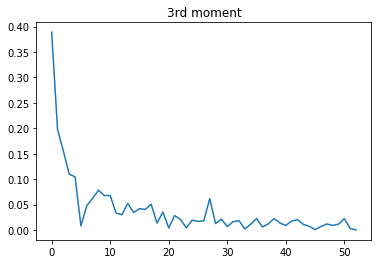



 NEW SIM. POPULATION = 10000
max time:  2500000.0
at t: 2500
at t: 5000
at t: 7500
at t: 10000
at t: 12500
at t: 15000
at t: 17500
at t: 20000
at t: 22500
at t: 25000
at t: 27500
at t: 30000
at t: 32500
at t: 35000
at t: 37500
at t: 40000
at t: 42500
at t: 45000
at t: 47500
at t: 50000
at t: 52500
at t: 55000
at t: 57500
at t: 60000
at t: 62500
at t: 65000
finished


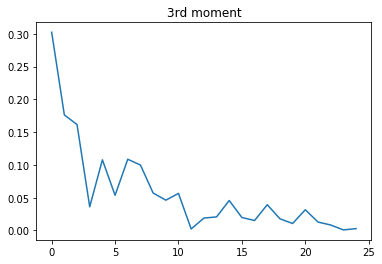



 NEW SIM. POPULATION = 13000
max time:  3250000.0
at t: 3250
at t: 6500
at t: 9750
at t: 13000
at t: 16250
at t: 19500
at t: 22750
at t: 26000
at t: 29250
at t: 32500
at t: 35750
at t: 39000
at t: 42250
at t: 45500
at t: 48750
at t: 52000
at t: 55250
at t: 58500
at t: 61750
at t: 65000
at t: 68250
at t: 71500
at t: 74750
at t: 78000
at t: 81250
at t: 84500
at t: 87750
at t: 91000
at t: 94250
finished


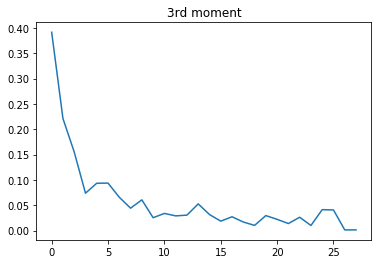



 NEW SIM. POPULATION = 15000
max time:  3750000.0
at t: 3750
at t: 7500
at t: 11250
at t: 15000
at t: 18750
at t: 22500
at t: 26250
at t: 30000
at t: 33750
at t: 37500
at t: 41250
at t: 45000
at t: 48750
at t: 52500
at t: 56250
at t: 60000
at t: 63750
at t: 67500
at t: 71250
at t: 75000
at t: 78750
at t: 82500
at t: 86250
at t: 90000
at t: 93750
at t: 97500
at t: 101250
at t: 105000
at t: 108750
at t: 112500
at t: 116250
at t: 120000
at t: 123750
at t: 127500
at t: 131250
at t: 135000
finished


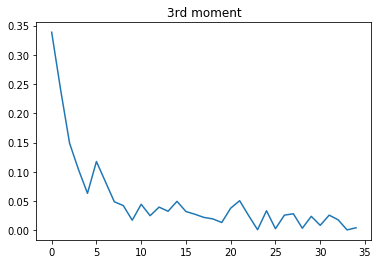

In [21]:
sim = Pure_Random(N=100,mu=50.)
populations=[250,1000,1000,2000,2000,3000,3000,4000,4500,5000,5500,6000,7000,7500,8000,8500,9000,10000,13000,15000]
# converge_params=[0.2,0.006,0.04]
converge_params=[0.0075]
converge_times = []
for pop in populations:
    print("\n\n NEW SIM. POPULATION = %s"%pop)
    sim.reset()
    sim.populate(n=pop,mu=sim.mu)
    sim.run(convergence="auto",debug=True,auto_converge_params=converge_params)
    dmdtvals = np.array(sim.dmdt_vals)
    #m2s,m3s,m4s = dmdtvals[:,0],dmdtvals[:,1],dmdtvals[:,2]
    m3s = dmdtvals[:,0]#,dmdtvals[:,1],dmdtvals[:,2]
    t = list(range(len(m3s)))
#     set_trace()
#     plt.figure()
#     plt.plot(t,m2s)
#     plt.title("2nd moment")
#     plt.show()
#     plt.close()
    plt.figure()
    plt.title("3rd moment")
    plt.plot(t,m3s)
    plt.show()
    plt.close()
    
    
    
    converge_times.append(sim.convergence_t)
#     plt.figure()
#     plt.plot(t,m4s)
#     plt.title("4th moment")
#     plt.show()
#     plt.close()
#     anim = sim.animate_distributions(times=[1,t[-2]],n_frames=50)
#     HTML(anim.to_jshtml())

#     sim.show()
#     print("RUNNING TO MAX:")
#     sim.reset()
#     sim.populate(n=pop,mu=sim.mu)
#     sim.run(convergence="manual")
#     sim.show()
            

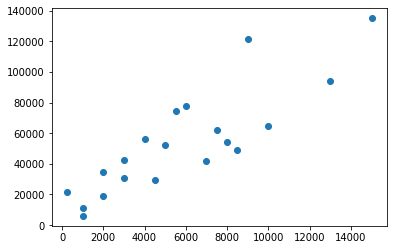

In [22]:
plt.plot(populations,converge_times,'o')



 NEW SIM. POPULATION = 100000
max time:  25000000.0
at t: 25000
at t: 50000
at t: 75000
at t: 100000
at t: 125000
at t: 150000
at t: 175000
at t: 200000
at t: 225000
at t: 250000
at t: 275000
at t: 300000
at t: 325000
at t: 350000
at t: 400000
at t: 425000
at t: 450000
at t: 475000
at t: 500000
at t: 525000
at t: 550000
at t: 575000
at t: 600000
at t: 650000
at t: 675000
at t: 700000
at t: 725000
at t: 750000
at t: 775000
at t: 800000
at t: 825000
at t: 850000
at t: 875000
at t: 900000
at t: 925000
at t: 950000
at t: 975000
at t: 1000000
at t: 1025000
at t: 1050000
at t: 1075000
at t: 1100000
at t: 1125000
at t: 1150000
at t: 1175000
has converged 1 times
at t: 1200000
at t: 1225000
at t: 1250000
has converged 1 times
at t: 1275000
at t: 1300000
at t: 1325000
at t: 1350000
at t: 1375000
at t: 1400000
at t: 1425000
has converged 1 times
at t: 1450000
at t: 1475000
has converged 1 times
at t: 1500000
at t: 1525000
has converged 1 times
at t: 1550000
at t: 1575000
at t: 1600000
at t: 16

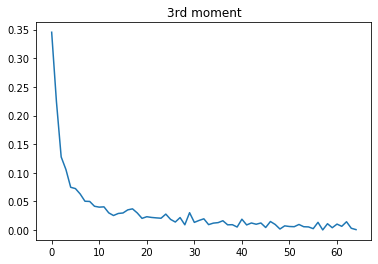

In [7]:
sim = Pure_Random(N=100,mu=50.)
populations=[10**5]
# converge_params=[0.2,0.006,0.04]
converge_params=[0.005]
for pop in populations:
    print("\n\n NEW SIM. POPULATION = %s"%pop)
    sim.reset()
    sim.populate(n=pop,mu=sim.mu)
    sim.run(convergence="auto",debug=True,auto_converge_params=converge_params)
    dmdtvals = np.array(sim.dmdt_vals)
    #m2s,m3s,m4s = dmdtvals[:,0],dmdtvals[:,1],dmdtvals[:,2]
    m3s = dmdtvals[:,0]#,dmdtvals[:,1],dmdtvals[:,2]
    t = list(range(len(m3s)))
#     set_trace()
#     plt.figure()
#     plt.plot(t,m2s)
#     plt.title("2nd moment")
#     plt.show()
#     plt.close()
    plt.figure()
    plt.title("3rd moment")
    plt.plot(t,m3s)
    plt.show()
    plt.close()
#     plt.figure()
#     plt.plot(t,m4s)
#     plt.title("4th moment")
#     plt.show()
#     plt.close()
#     anim = sim.animate_distributions(times=[1,t[-2]],n_frames=50)
#     HTML(anim.to_jshtml())

#     sim.show()
#     print("RUNNING TO MAX:")
#     sim.reset()
#     sim.populate(n=pop,mu=sim.mu)
#     sim.run(convergence="manual")
#     sim.show()
            

   t    Gini stdev   1%  10%  50%  90%  99%


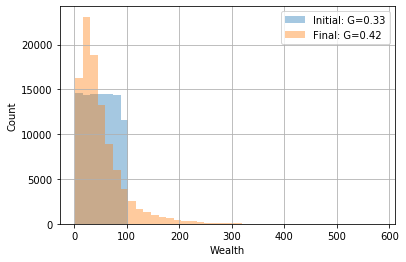

In [8]:
sim.show()

In [19]:
# Simulation with purely random interactions

class Random_Net(Pure_Random):
    
    
    
    ### NOTE (from NetworkX): "You should not change the node object if the hash depends on its contents."

    
    class Agent:
        def __init__(self,income=0.,lambda_=0.):
            self.income = income  
            self.lambda_ = lambda_
            

    #initial values (population size & mean of the income distribution)
    def populate(self,n=500,mu=50.):
        """
        initialize population with distribution of income and parameters (e.g. lambda) applied to agents
        within structure (e.g. grid)
        
        """
        self.N=n
        self.time = 0
        incomes = [np.random.uniform(0, mu*2.) for actor in range(n)]
        
        # lambda values
        min_lambda = 0.2
        max_lambda = 0.9
        lambda_ = np.random.power(0.3,n)
        # rescale lambda
        lambda_ *= max_lambda - min_lambda
        lambda_ += min_lambda
        
        
        maxlambda = 0.97
        i = 0
        # make sure no lambdas are above 1
        for l in lambda_:
            if l >=maxlambda:
                lambda_[i] = np.random.power(.3)
                if lambda_[i]>=maxlambda:
                    lambda_[i] = 0.9
            i+=1
                
        self.population = []
        for inc,lam in zip(incomes,lambda_):
            self.population.append(self.Agent(income=inc,lambda_=lam))
        
        self.network = nx.gnp_random_graph(n, 0.001, directed=False)
        self.population = np.array(self.population)
    
  
    
    def choose_agents(self):
        """
        Input: None
        
        Output: A pair of agents who are going to interact. This becomes the input to interact
       
        Takes two actors randomly

        """
        loc_a,loc_b = random.choice(list(self.network.edges))
        return self.population[loc_a],self.population[loc_b]
 

max time:  250000.0
at t: 250
at t: 500
at t: 750
at t: 1000
at t: 1250
at t: 1500
at t: 1750
at t: 2000
at t: 2250
at t: 2500
at t: 2750
at t: 3000
at t: 3250
at t: 3500
at t: 3750
at t: 4000
at t: 4250
at t: 4500
at t: 4750
at t: 5000
at t: 5250
at t: 5500
at t: 5750
at t: 6000
at t: 6250
at t: 6500
at t: 6750
at t: 7000
at t: 7250
at t: 7500
at t: 7750
at t: 8000
at t: 8250
at t: 8500
at t: 8750
at t: 9000
at t: 9250
at t: 9500
at t: 9750
at t: 10000
at t: 10250
at t: 10500
at t: 10750
at t: 11000
at t: 11250
at t: 11500
at t: 11750
at t: 12000
at t: 12250
at t: 12500
at t: 12750
at t: 13000
at t: 13250
at t: 13500
at t: 13750
at t: 14000
at t: 14250
at t: 14500
at t: 14750
at t: 15000
at t: 15250
at t: 15500
at t: 15750
at t: 16000
at t: 16250
at t: 16500
at t: 16750
at t: 17000
at t: 17250
at t: 17500
at t: 17750
at t: 18000
at t: 18250
at t: 18500
at t: 18750
at t: 19000
at t: 19250
at t: 19500
at t: 19750
at t: 20000
at t: 20250
at t: 20500
at t: 20750
at t: 21000
at t: 21250
at

at t: 166000
at t: 166250
at t: 166500
at t: 166750
at t: 167000
at t: 167250
at t: 167500
at t: 167750
at t: 168000
at t: 168250
at t: 168500
at t: 168750
at t: 169000
at t: 169250
at t: 169500
at t: 169750
at t: 170000
at t: 170250
at t: 170500
at t: 170750
at t: 171000
at t: 171250
at t: 171500
at t: 171750
at t: 172000
at t: 172250
at t: 172500
at t: 172750
at t: 173000
at t: 173250
at t: 173500
at t: 173750
at t: 174000
at t: 174250
at t: 174500
at t: 174750
at t: 175000
at t: 175250
at t: 175500
at t: 175750
at t: 176000
at t: 176250
at t: 176500
at t: 176750
at t: 177000
at t: 177250
at t: 177500
at t: 177750
at t: 178000
at t: 178250
at t: 178500
at t: 178750
at t: 179000
at t: 179250
at t: 179500
at t: 179750
at t: 180000
at t: 180250
at t: 180500
at t: 180750
at t: 181000
at t: 181250
at t: 181500
at t: 181750
at t: 182000
at t: 182250
at t: 182500
at t: 182750
at t: 183000
at t: 183250
at t: 183500
at t: 183750
at t: 184000
at t: 184250
at t: 184500
at t: 184750
at t: 185000

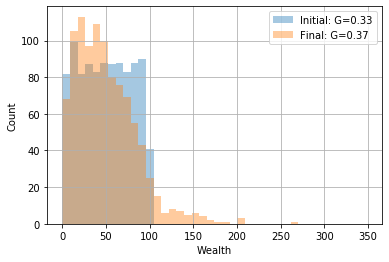

In [20]:
netsim = Random_Net(N=1000,mu=50.)
netsim.run()
netsim.show()

final time:  20000.0
at t: 0
at t: 500
at t: 1000
at t: 1500
at t: 2000
at t: 2500
at t: 3000
at t: 3500
at t: 4000
at t: 4500
at t: 5000
at t: 5500
at t: 6000
at t: 6500
at t: 7000
at t: 7500
at t: 8000
at t: 8500
at t: 9000
at t: 9500
at t: 10000
at t: 10500
at t: 11000
at t: 11500
at t: 12000
at t: 12500
at t: 13000
at t: 13500
at t: 14000
at t: 14500
at t: 15000
at t: 15500
at t: 16000
at t: 16500
at t: 17000
at t: 17500
at t: 18000
at t: 18500
at t: 19000
at t: 19500
at t: 20000
finished
20000


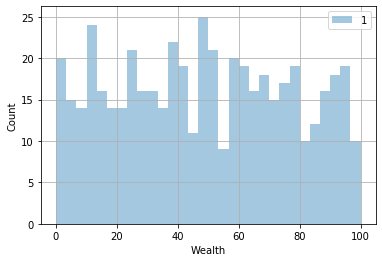

In [14]:
p = 500
sim = Pure_Random(N=p,mu=50.)
sim.run()
print(sim.time)
anim = sim.animate_distributions(times=(1,100),n_frames=100,average=False)
HTML(anim.to_jshtml())

In [46]:
# meta_sim = General_Model_MultiCity(Pure_Random)
meta_sim.save_results(name="KEM_Rand_larger")
meta_sim.run_many_pops(add=True,pops=[13000,14000,15000,17000,20000,25000,30000,35000,40000,50000])


popsizes: [100, 500, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 11000, 12000, 13000, 14000, 15000, 17000, 20000, 25000, 30000, 35000, 40000, 50000]

 NEW SIM
population =  13000
max time:  3250000.0
at t: 32500
at t: 65000
at t: 97500
at t: 130000
at t: 162500
at t: 195000
at t: 227500
at t: 260000
at t: 292500
at t: 325000
at t: 357500
finished

 NEW SIM
population =  14000
max time:  3500000.0
at t: 35000
at t: 70000
at t: 105000
at t: 140000
at t: 175000
at t: 210000
at t: 245000
at t: 280000
at t: 315000
at t: 350000
at t: 385000
finished

 NEW SIM
population =  15000
max time:  3750000.0
at t: 37500
at t: 75000
at t: 112500
at t: 150000
finished

 NEW SIM
population =  17000
max time:  4250000.0
at t: 42500
at t: 85000
at t: 127500
at t: 170000
at t: 212500
at t: 255000
at t: 297500
at t: 340000
at t: 382500
finished

 NEW SIM
population =  20000
max time:  5000000.0
at t: 50000
at t: 100000
at t: 150000
at t: 200000
finished

 NEW SIM
population =  25000
max tim

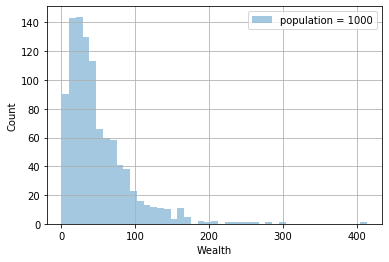

In [38]:

anim = meta_sim.animate_population_dists()
HTML(anim.to_jshtml())

final time:  400.0
at t: 0
at t: 10
at t: 20
at t: 30
at t: 40
at t: 50
at t: 60
at t: 70
at t: 80
at t: 90
at t: 100
at t: 110
at t: 120
at t: 130
at t: 140
at t: 150
at t: 160
at t: 170
at t: 180
at t: 190
at t: 200
at t: 210
at t: 220
at t: 230
at t: 240
at t: 250
at t: 260
at t: 270
at t: 280
at t: 290
at t: 300
at t: 310
at t: 320
at t: 330
at t: 340
at t: 350
at t: 360
at t: 370
at t: 380
at t: 390
at t: 400
finished
Population: 10


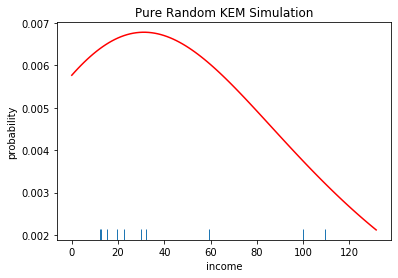

final time:  4000.0
at t: 0
at t: 100
at t: 200
at t: 300
at t: 400
at t: 500
at t: 600
at t: 700
at t: 800
at t: 900
at t: 1000
at t: 1100
at t: 1200
at t: 1300
at t: 1400
at t: 1500
at t: 1600
at t: 1700
at t: 1800
at t: 1900
at t: 2000
at t: 2100
at t: 2200
at t: 2300
at t: 2400
at t: 2500
at t: 2600
at t: 2700
at t: 2800
at t: 2900
at t: 3000
at t: 3100
at t: 3200
at t: 3300
at t: 3400
at t: 3500
at t: 3600
at t: 3700
at t: 3800
at t: 3900
at t: 4000
finished
Population: 100


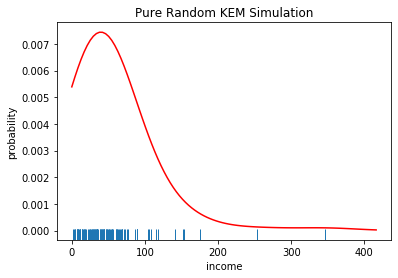

final time:  40000.0
at t: 0
at t: 1000
at t: 2000
at t: 3000
at t: 4000
at t: 5000
at t: 6000
at t: 7000
at t: 8000
at t: 9000
at t: 10000
at t: 11000
at t: 12000
at t: 13000
at t: 14000
at t: 15000
at t: 16000
at t: 17000
at t: 18000
at t: 19000
at t: 20000
at t: 21000
at t: 22000
at t: 23000
at t: 24000
at t: 25000
at t: 26000
at t: 27000
at t: 28000
at t: 29000
at t: 30000
at t: 31000
at t: 32000
at t: 33000
at t: 34000
at t: 35000
at t: 36000
at t: 37000
at t: 38000
at t: 39000
at t: 40000
finished
Population: 1000


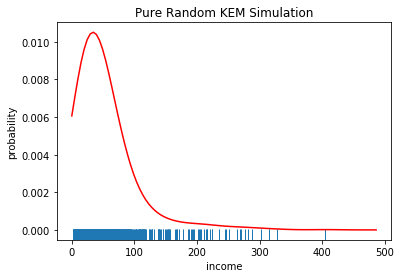

final time:  400000.0
at t: 0
at t: 10000
at t: 20000
at t: 30000
at t: 40000
at t: 50000
at t: 60000
at t: 70000
at t: 80000
at t: 90000
at t: 100000
at t: 110000
at t: 120000
at t: 130000
at t: 140000
at t: 150000
at t: 160000
at t: 170000
at t: 180000
at t: 190000
at t: 200000
at t: 210000
at t: 220000
at t: 230000
at t: 240000
at t: 250000
at t: 260000
at t: 270000
at t: 280000
at t: 290000
at t: 300000
at t: 310000
at t: 320000
at t: 330000
at t: 340000
at t: 350000
at t: 360000
at t: 370000
at t: 380000
at t: 390000
at t: 400000
finished
Population: 10000


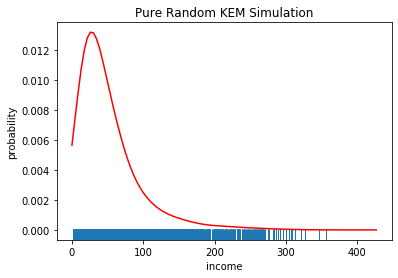

final time:  4000000.0
at t: 0


KeyboardInterrupt: 

In [38]:
pops = [10,100,1000,10000,100000]
for pop in pops:
    sim = Pure_Random(N=pop,mu=50.)
    sim.run(convergence="manual")
    print("Population:",sim.N)
    sim.kde_dist()

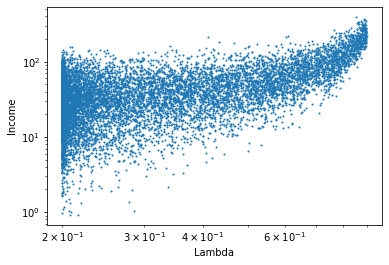